# MasakhaNER Project: Named Entity Recognition for African Languages

## Introduction and Problem Statement

This notebook explores Named Entity Recognition (NER) for low-resource African languages using the MasakhaNER dataset. NER is a fundamental NLP task that identifies and classifies named entities in text into predefined categories such as person names, organizations, locations, and dates.

The MasakhaNER dataset covers 10 African languages: Amharic, Hausa, Igbo, Kinyarwanda, Luganda, Luo, Nigerian-Pidgin, Swahili, Wolof, and Yorùbá. This project addresses the challenge of developing effective NLP tools for languages with limited digital resources.

### Project Goals:
1. Explore and analyze the MasakhaNER dataset
2. Implement preprocessing pipelines for African languages
3. Develop and compare different NER models
4. Evaluate model performance across languages


### Set Up and Data Loading

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForTokenClassification
from tqdm.notebook import tqdm
import requests
import zipfile
import io

# Set display options
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Data Loading and Preparation

We'll download the MasakhaNER dataset and load it into our environment. The dataset is structured in CoNLL format, with one token per line and entity tags in BIO format.

In [2]:
def download_masakhaner_dataset():
    """
    Download the MasakhaNER dataset from GitHub if not already present

    Returns:
        Path to the dataset directory
    """
    # Define the URL and directory
    url = "https://github.com/masakhane-io/masakhane-ner/archive/refs/heads/main.zip"
    data_dir = "masakhane-ner-data"

    # Check if directory already exists
    if os.path.exists(data_dir):
        print(f"Dataset directory already exists at {data_dir}")
        return data_dir

    # Download and extract the dataset
    print("Downloading MasakhaNER dataset...")
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        # Extract only the data directory to save space
        for file in zip_ref.namelist():
            if file.startswith('masakhane-ner-main/data/'):
                zip_ref.extract(file, '.')

    # Rename the directory for easier access
    os.rename('masakhane-ner-main/data', data_dir)

    # Clean up
    os.rmdir('masakhane-ner-main')

    print(f"Dataset downloaded and extracted to {data_dir}")
    return data_dir

def load_masakhaner_data(data_dir, languages=None, sample_size=None):
    """
    Load the MasakhaNER dataset for specified languages.

    Args:
        data_dir: Path to the directory containing MasakhaNER data
        languages: List of languages to load (if None, load all available)
        sample_size: If specified, load only this many examples per language and split

    Returns:
        Dictionary mapping language codes to their respective datasets
    """
    if languages is None:
        # All 10 languages in MasakhaNER
        languages = ['amh', 'hau', 'ibo', 'kin', 'lug', 'luo', 'pcm', 'swa', 'wol', 'yor']

    datasets = {}

    for lang in languages:
        lang_data = []

        # Load train, dev, and test sets
        for split in ['train', 'dev', 'test']:
            file_path = os.path.join(data_dir, lang, f"{split}.txt")

            if not os.path.exists(file_path):
                print(f"Warning: File not found: {file_path}")
                continue

            current_sentence = []
            sentences = []

            # Read the CoNLL formatted file
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()

                    if line:
                        # Parse CoNLL format: word, tag
                        parts = line.split()
                        if len(parts) >= 2:
                            word, tag = parts[0], parts[-1]  # Last column is the NER tag
                            current_sentence.append((word, tag))
                    elif current_sentence:
                        # End of sentence
                        sentences.append(current_sentence)
                        current_sentence = []

            # Don't forget the last sentence if file doesn't end with an empty line
            if current_sentence:
                sentences.append(current_sentence)

            # Sample if needed
            if sample_size and len(sentences) > sample_size:
                sentences = sentences[:sample_size]

            # Convert to DataFrame format
            for sentence in sentences:
                lang_data.append({
                    'tokens': [word for word, _ in sentence],
                    'tags': [tag for _, tag in sentence],
                    'split': split
                })

        datasets[lang] = pd.DataFrame(lang_data)
        print(f"Loaded {len(datasets[lang])} sentences for {lang}")

    return datasets

# Download and load the dataset
data_dir = download_masakhaner_dataset()

# For quick testing, let's use a smaller sample. Remove the sample_size parameter for the full dataset.
# For final analysis, use all data with: datasets = load_masakhaner_data(data_dir)
datasets = load_masakhaner_data(data_dir, sample_size=100)

# Display a sample from Swahili dataset
print("\nSample from Swahili (swa) dataset:")
sample_row = datasets['swa'].iloc[0]
print(f"Tokens: {sample_row['tokens']}")
print(f"Tags: {sample_row['tags']}")
print(f"Split: {sample_row['split']}")

Dataset downloaded and extracted to masakhane-ner-data
Loaded 300 sentences for amh
Loaded 300 sentences for hau
Loaded 300 sentences for ibo
Loaded 300 sentences for kin
Loaded 300 sentences for lug
Loaded 292 sentences for luo
Loaded 300 sentences for pcm
Loaded 300 sentences for swa
Loaded 300 sentences for wol
Loaded 300 sentences for yor

Sample from Swahili (swa) dataset:
Tokens: ['Wizara', 'ya', 'afya', 'ya', 'Tanzania', 'imeripoti', 'Jumatatu', 'kuwa', ',', 'watu', 'takriban', '14', 'zaidi', 'wamepata', 'maambukizi', 'ya', 'Covid', '-', '19', '.']
Tags: ['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'B-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Split: train


## Exploratory Data Analysis

Now, let's explore the MasakhaNER dataset to understand its characteristics across different languages.

Dataset Statistics:
                sentences tokens entities entity_density         entity_types  \
Amharic               300   4486      636         14.18%  DATE, LOC, ORG, PER   
Hausa                 300   8859     1129         12.74%  DATE, LOC, ORG, PER   
Igbo                  300   6046      876         14.49%  DATE, LOC, ORG, PER   
Kinyarwanda           300   6940      938         13.52%  DATE, LOC, ORG, PER   
Luganda               300   6350     1112         17.51%  DATE, LOC, ORG, PER   
Luo                   292   7759     1156         14.90%  DATE, LOC, ORG, PER   
Nigerian-Pidgin       300   8120     1044         12.86%  DATE, LOC, ORG, PER   
Swahili               300   7138      692          9.69%  DATE, LOC, ORG, PER   
Wolof                 300   6139      454          7.40%  DATE, LOC, ORG, PER   
Yorùbá                300   7945      866         10.90%  DATE, LOC, ORG, PER   

                avg_sentence_len  
Amharic                     15.0  
Hausa             

<Figure size 1400x800 with 0 Axes>

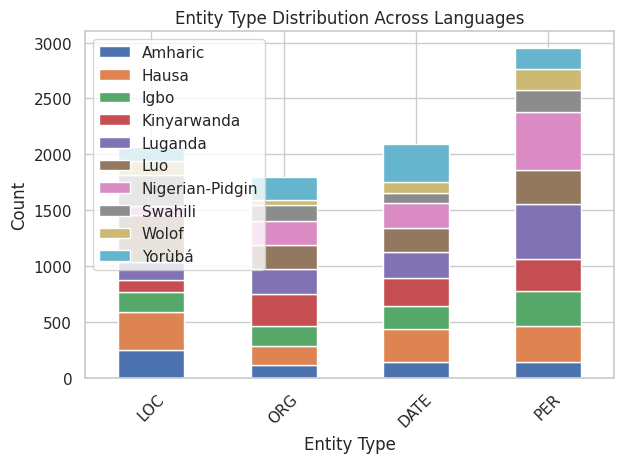

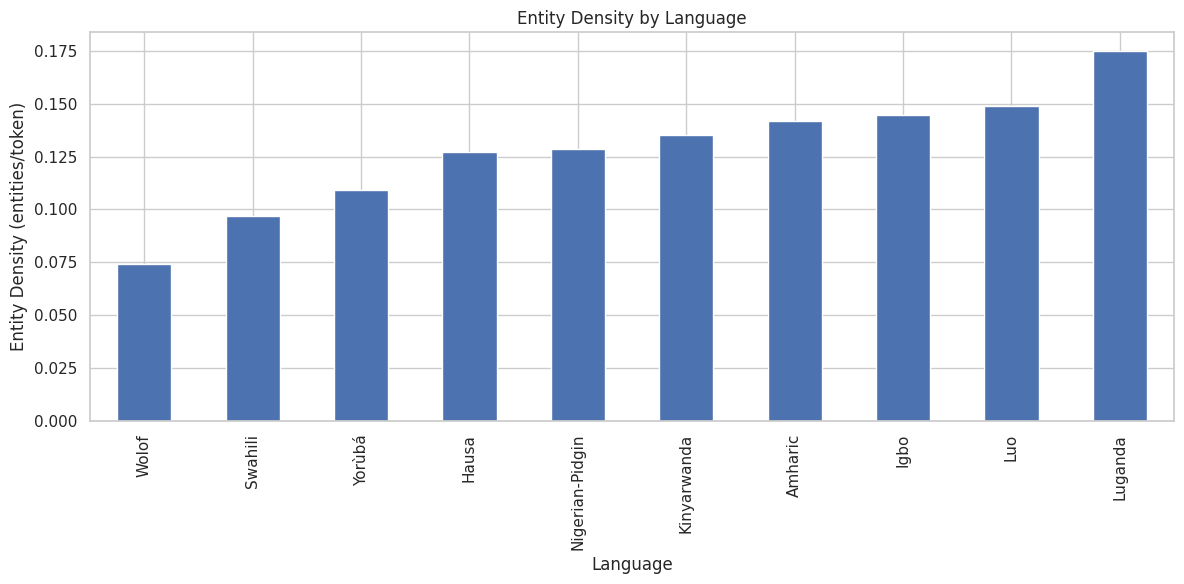

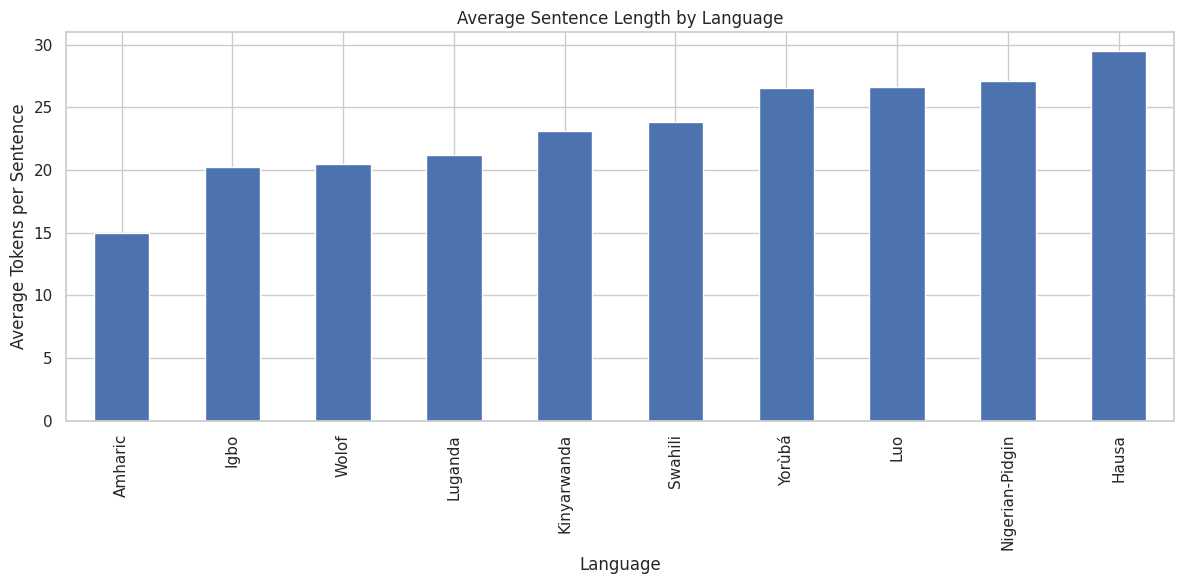


Entity tag distribution for Swahili:
      Tag  Count  Percentage
0       O   6446   90.305408
1   B-LOC    225    3.152143
2   B-PER    123    1.723172
3   B-ORG     78    1.092743
4  B-DATE     76    1.064724
5   I-PER     68    0.952648
6   I-ORG     59    0.826562
7   I-LOC     49    0.686467
8  I-DATE     14    0.196133


<Figure size 1200x600 with 0 Axes>

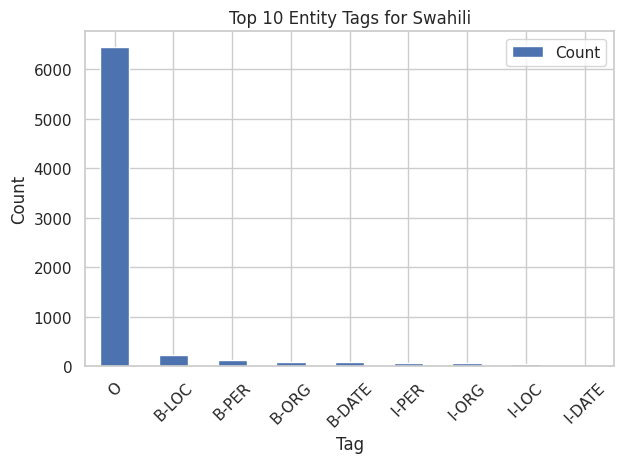


Token Distribution Statistics:
                 total_tokens  unique_tokens vocabulary_ratio
Amharic                4486.0         2610.0           58.18%
Hausa                  8859.0         2158.0           24.36%
Igbo                   6046.0         1617.0           26.74%
Kinyarwanda            6940.0         2446.0           35.24%
Luganda                6350.0         3175.0           50.00%
Luo                    7759.0         2147.0           27.67%
Nigerian-Pidgin        8120.0         2023.0           24.91%
Swahili                7138.0         2168.0           30.37%
Wolof                  6139.0         1725.0           28.10%
Yorùbá                 7945.0         1717.0           21.61%


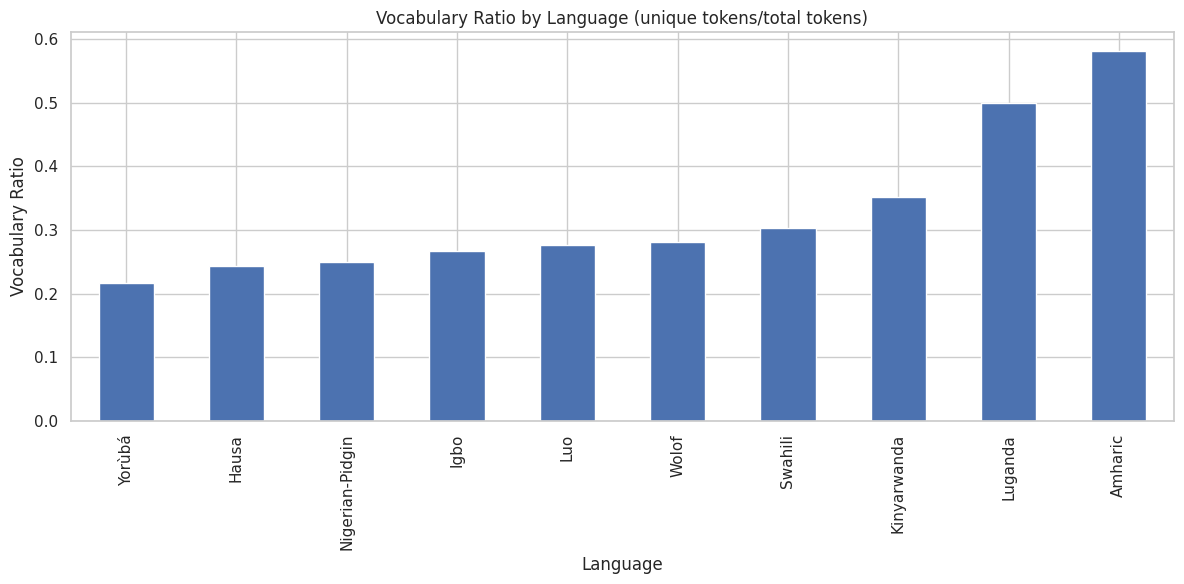

In [4]:
def explore_dataset(datasets):
    """
    Perform exploratory analysis on the MasakhaNER dataset

    Args:
        datasets: Dictionary mapping language codes to their respective datasets

    Returns:
        Tuple of DataFrames with dataset statistics and entity distribution
    """
    # Overall statistics
    print("Dataset Statistics:")
    stats = {}

    for lang, df in datasets.items():
        # Language name mapping for better readability
        lang_names = {
            'amh': 'Amharic', 'hau': 'Hausa', 'ibo': 'Igbo',
            'kin': 'Kinyarwanda', 'lug': 'Luganda', 'luo': 'Luo',
            'pcm': 'Nigerian-Pidgin', 'swa': 'Swahili', 'wol': 'Wolof',
            'yor': 'Yorùbá'
        }

        # Count sentences, tokens, and entities
        num_sentences = len(df)
        num_tokens = sum(df['tokens'].apply(len))

        # Count entities (non-O tags)
        all_tags = [tag for tags in df['tags'] for tag in tags]
        entity_tags = [tag for tag in all_tags if tag != 'O']
        num_entities = len(entity_tags)

        # Count entity types
        entity_types = set([tag.split('-')[1] if '-' in tag else tag for tag in entity_tags if tag != 'O'])

        # Average sentence length
        avg_sentence_len = num_tokens / num_sentences if num_sentences > 0 else 0

        # Store statistics
        stats[lang_names.get(lang, lang)] = {
            'sentences': num_sentences,
            'tokens': num_tokens,
            'entities': num_entities,
            'entity_density': num_entities / num_tokens if num_tokens > 0 else 0,
            'entity_types': ', '.join(sorted(entity_types)) if entity_types else 'None',
            'avg_sentence_len': avg_sentence_len
        }

    stats_df = pd.DataFrame(stats).T

    # Format the columns for better readability
    stats_df['entity_density'] = stats_df['entity_density'].map('{:.2%}'.format)
    stats_df['avg_sentence_len'] = stats_df['avg_sentence_len'].map('{:.1f}'.format)

    print(stats_df)

    # Visualize entity type distribution
    entity_counts = {}

    for lang, df in datasets.items():
        lang_name = {'amh': 'Amharic', 'hau': 'Hausa', 'ibo': 'Igbo',
                    'kin': 'Kinyarwanda', 'lug': 'Luganda', 'luo': 'Luo',
                    'pcm': 'Nigerian-Pidgin', 'swa': 'Swahili', 'wol': 'Wolof',
                    'yor': 'Yorùbá'}.get(lang, lang)

        # Get all entity tags and count them by type
        all_tag_types = []
        for tags in df['tags']:
            for tag in tags:
                if tag != 'O':  # Skip non-entity tags
                    # Extract the entity type (e.g., PER from B-PER)
                    entity_type = tag.split('-')[1] if '-' in tag else tag
                    all_tag_types.append(entity_type)

        entity_counts[lang_name] = Counter(all_tag_types)

    # Convert to DataFrame for easier plotting
    entity_df = pd.DataFrame(entity_counts).fillna(0)

    # Plot entity type distribution
    plt.figure(figsize=(14, 8))
    entity_df.plot(kind='bar', stacked=True)
    plt.title('Entity Type Distribution Across Languages')
    plt.ylabel('Count')
    plt.xlabel('Entity Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot entity density by language
    plt.figure(figsize=(12, 6))
    entity_density = pd.Series({k: float(v.strip('%'))/100
                               for k, v in stats_df['entity_density'].items()})
    entity_density.sort_values().plot(kind='bar')
    plt.title('Entity Density by Language')
    plt.ylabel('Entity Density (entities/token)')
    plt.xlabel('Language')
    plt.tight_layout()
    plt.show()

    # Plot average sentence length by language
    plt.figure(figsize=(12, 6))
    avg_sent_len = pd.Series({k: float(v) for k, v in stats_df['avg_sentence_len'].items()})
    avg_sent_len.sort_values().plot(kind='bar')
    plt.title('Average Sentence Length by Language')
    plt.ylabel('Average Tokens per Sentence')
    plt.xlabel('Language')
    plt.tight_layout()
    plt.show()

    return stats_df, entity_df

# Run exploratory data analysis
stats_df, entity_df = explore_dataset(datasets)

# Additional analysis: Look at tag distribution for a specific language
def analyze_entity_distribution(df, lang_name):
    """Analyze entity distribution for a specific language"""
    all_tags = [tag for tags in df['tags'] for tag in tags]
    tag_counts = Counter(all_tags)

    # Create a DataFrame for better display
    tag_df = pd.DataFrame({
        'Tag': list(tag_counts.keys()),
        'Count': list(tag_counts.values())
    })
    tag_df = tag_df.sort_values('Count', ascending=False).reset_index(drop=True)

    # Calculate percentages
    total = tag_df['Count'].sum()
    tag_df['Percentage'] = tag_df['Count'] / total * 100

    print(f"\nEntity tag distribution for {lang_name}:")
    print(tag_df)

    # Plot the distribution
    plt.figure(figsize=(12, 6))
    ax = tag_df.head(10).plot(kind='bar', x='Tag', y='Count')
    plt.title(f'Top 10 Entity Tags for {lang_name}')
    plt.ylabel('Count')
    plt.xlabel('Tag')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return tag_df

# Analyze entity distribution for Swahili
swahili_tag_df = analyze_entity_distribution(datasets['swa'], 'Swahili')

# Analyze token distribution (how many unique tokens)
def analyze_token_distribution(datasets):
    """Analyze token distributions across languages"""
    token_stats = {}

    for lang, df in datasets.items():
        lang_name = {'amh': 'Amharic', 'hau': 'Hausa', 'ibo': 'Igbo',
                    'kin': 'Kinyarwanda', 'lug': 'Luganda', 'luo': 'Luo',
                    'pcm': 'Nigerian-Pidgin', 'swa': 'Swahili', 'wol': 'Wolof',
                    'yor': 'Yorùbá'}.get(lang, lang)

        # Get all tokens
        all_tokens = [token for tokens in df['tokens'] for token in tokens]
        unique_tokens = set(all_tokens)

        token_stats[lang_name] = {
            'total_tokens': len(all_tokens),
            'unique_tokens': len(unique_tokens),
            'vocabulary_ratio': len(unique_tokens) / len(all_tokens) if all_tokens else 0
        }

    token_stats_df = pd.DataFrame(token_stats).T
    token_stats_df['vocabulary_ratio'] = token_stats_df['vocabulary_ratio'].map('{:.2%}'.format)

    print("\nToken Distribution Statistics:")
    print(token_stats_df)

    # Plot vocabulary ratio by language
    plt.figure(figsize=(12, 6))
    vocab_ratio = pd.Series({k: float(v.strip('%'))/100
                            for k, v in token_stats_df['vocabulary_ratio'].items()})
    vocab_ratio.sort_values().plot(kind='bar')
    plt.title('Vocabulary Ratio by Language (unique tokens/total tokens)')
    plt.ylabel('Vocabulary Ratio')
    plt.xlabel('Language')
    plt.tight_layout()
    plt.show()

    return token_stats_df

# Analyze token distribution
token_stats_df = analyze_token_distribution(datasets)

## Data Preprocessing

Now, let's preprocess the data to prepare it for model training. This involves:
1. Converting tags to numerical indices
2. Creating token vocabularies
3. Preparing data loaders for model training

In [5]:
def preprocess_data(datasets):
    """
    Preprocess the MasakhaNER dataset for modeling.

    Args:
        datasets: Dictionary mapping language codes to their respective datasets

    Returns:
        Preprocessed datasets ready for modeling
    """
    preprocessed = {}

    for lang, df in datasets.items():
        print(f"Preprocessing {lang}...")

        # Create tag vocabulary - map each tag to a unique index
        all_tags = sorted(set([tag for tags in df['tags'] for tag in tags]))
        tag2idx = {tag: idx for idx, tag in enumerate(all_tags)}
        idx2tag = {idx: tag for tag, idx in tag2idx.items()}

        # Create word vocabulary - map each word to a unique index
        all_words = sorted(set([word.lower() for tokens in df['tokens'] for word in tokens]))
        word2idx = {word: idx+1 for idx, word in enumerate(all_words)}  # Reserve 0 for padding

        # Add preprocessed data
        preprocessed[lang] = {
            'data': df,
            'tag2idx': tag2idx,
            'idx2tag': idx2tag,
            'word2idx': word2idx,
            'n_tags': len(tag2idx),
            'n_words': len(word2idx)
        }

        # Create train/val/test splits (MasakhaNER already has these)
        train_df = df[df['split'] == 'train'].reset_index(drop=True)
        val_df = df[df['split'] == 'dev'].reset_index(drop=True)
        test_df = df[df['split'] == 'test'].reset_index(drop=True)

        preprocessed[lang]['train'] = train_df
        preprocessed[lang]['val'] = val_df
        preprocessed[lang]['test'] = test_df

        print(f"  Vocabulary size: {len(word2idx)} words")
        print(f"  Tag set size: {len(tag2idx)} tags")
        print(f"  Train set: {len(train_df)} sentences")
        print(f"  Validation set: {len(val_df)} sentences")
        print(f"  Test set: {len(test_df)} sentences")

    return preprocessed

# Custom dataset class for NER
class NERDataset(Dataset):
    """
    Custom PyTorch Dataset for Named Entity Recognition

    This class handles:
    - Converting tokens to indices
    - Converting tags to indices
    - Padding sequences to a fixed length
    """
    def __init__(self, sentences, tags, word2idx, tag2idx, max_len=128):
        self.sentences = sentences
        self.tags = tags
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        tags = self.tags[idx]

        # Convert words and tags to indices
        # For unknown words, use len(word2idx) as the index
        word_ids = [self.word2idx.get(word.lower(), len(self.word2idx)) for word in words]
        tag_ids = [self.tag2idx[tag] for tag in tags]

        # Handle sequences longer than max_len by truncating
        if len(word_ids) > self.max_len:
            word_ids = word_ids[:self.max_len]
            tag_ids = tag_ids[:self.max_len]

        # Create attention mask (1 for actual tokens, 0 for padding)
        attention_mask = [1] * len(word_ids)

        # Pad shorter sequences to max_len
        padding_length = self.max_len - len(word_ids)
        if padding_length > 0:
            # Pad word_ids and attention_mask with 0s
            word_ids = word_ids + [0] * padding_length
            attention_mask = attention_mask + [0] * padding_length

            # Pad tag_ids with -100 (ignored by the loss function)
            tag_ids = tag_ids + [-100] * padding_length

        return {
            'input_ids': torch.tensor(word_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(tag_ids, dtype=torch.long)
        }

def create_dataloaders(preprocessed_data, lang, batch_size=16):
    """
    Create PyTorch DataLoaders for training and evaluation

    Args:
        preprocessed_data: Preprocessed dataset dictionary
        lang: Language code
        batch_size: Batch size for training

    Returns:
        Tuple of (train_loader, val_loader, test_loader)
    """
    # Extract data for the language
    lang_data = preprocessed_data[lang]
    word2idx = lang_data['word2idx']
    tag2idx = lang_data['tag2idx']

    # Create datasets
    train_dataset = NERDataset(
        lang_data['train']['tokens'].tolist(),
        lang_data['train']['tags'].tolist(),
        word2idx, tag2idx
    )

    val_dataset = NERDataset(
        lang_data['val']['tokens'].tolist(),
        lang_data['val']['tags'].tolist(),
        word2idx, tag2idx
    )

    test_dataset = NERDataset(
        lang_data['test']['tokens'].tolist(),
        lang_data['test']['tags'].tolist(),
        word2idx, tag2idx
    )

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

# Preprocess the datasets
preprocessed_data = preprocess_data(datasets)

# Choose a language for model development (e.g., Swahili)
selected_lang = 'swa'
train_loader, val_loader, test_loader = create_dataloaders(
    preprocessed_data, selected_lang, batch_size=16
)

# Check a batch from the dataloader
batch = next(iter(train_loader))
print(f"\nSample batch shape - input_ids: {batch['input_ids'].shape}, labels: {batch['labels'].shape}")

Preprocessing amh...
  Vocabulary size: 2610 words
  Tag set size: 9 tags
  Train set: 100 sentences
  Validation set: 100 sentences
  Test set: 100 sentences
Preprocessing hau...
  Vocabulary size: 1877 words
  Tag set size: 9 tags
  Train set: 100 sentences
  Validation set: 100 sentences
  Test set: 100 sentences
Preprocessing ibo...
  Vocabulary size: 1528 words
  Tag set size: 9 tags
  Train set: 100 sentences
  Validation set: 100 sentences
  Test set: 100 sentences
Preprocessing kin...
  Vocabulary size: 2333 words
  Tag set size: 9 tags
  Train set: 100 sentences
  Validation set: 100 sentences
  Test set: 100 sentences
Preprocessing lug...
  Vocabulary size: 3080 words
  Tag set size: 9 tags
  Train set: 100 sentences
  Validation set: 100 sentences
  Test set: 100 sentences
Preprocessing luo...
  Vocabulary size: 1980 words
  Tag set size: 9 tags
  Train set: 100 sentences
  Validation set: 92 sentences
  Test set: 100 sentences
Preprocessing pcm...
  Vocabulary size: 1863 wo

## Model Development

Now let's implement different NER models, starting with a simple BiLSTM model and then exploring more complex architectures.

Model initialized with 2018 vocabulary size and 9 tag size
BiLSTM_NER(
  (embedding): Embedding(2019, 100, padding_idx=0)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=9, bias=True)
)


Epoch 1/3 (Training):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/3 (Validation):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/3, Train Loss: 2.0362, Val Loss: 1.8524
  New best model saved! (Validation Loss: 1.8524)


Epoch 2/3 (Training):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/3 (Validation):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/3, Train Loss: 1.6339, Val Loss: 1.2399
  New best model saved! (Validation Loss: 1.2399)


Epoch 3/3 (Training):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/3 (Validation):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/3, Train Loss: 0.8953, Val Loss: 0.4388
  New best model saved! (Validation Loss: 0.4388)


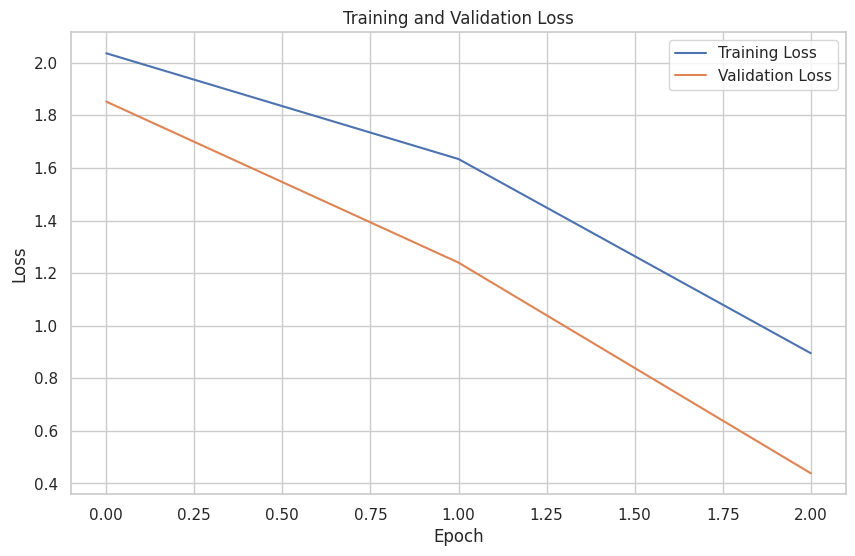

In [6]:
# BiLSTM model for NER
class BiLSTM_NER(nn.Module):
    """
    Bidirectional LSTM model for Named Entity Recognition

    This model consists of:
    1. An embedding layer to convert token IDs to vectors
    2. A bidirectional LSTM to capture context in both directions
    3. A fully connected layer to predict tag probabilities for each token
    """
    def __init__(self, vocab_size, tag_size, embedding_dim=100, hidden_dim=128, num_layers=2, dropout=0.5):
        super(BiLSTM_NER, self).__init__()

        # Embedding layer - converts token IDs to vectors
        # vocab_size + 1 to account for unknown words
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim, padding_idx=0)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            embedding_dim,       # Input dimension
            hidden_dim // 2,     # Hidden dimension (divided by 2 since bidirectional will double it)
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,    # Input shape is (batch_size, seq_len, features)
            dropout=dropout if num_layers > 1 else 0
        )

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer for tag prediction
        self.fc = nn.Linear(hidden_dim, tag_size)

    def forward(self, x, attention_mask=None):
        """
        Forward pass of the BiLSTM model

        Args:
            x: Token IDs of shape (batch_size, seq_len)
            attention_mask: Optional mask for padding tokens

        Returns:
            Tag logits of shape (batch_size, seq_len, tag_size)
        """
        # Get embeddings
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # Apply attention mask if provided (for handling padding)
        if attention_mask is not None:
            # Expand mask to match embedding dimensions
            mask = attention_mask.unsqueeze(-1).expand_as(x)
            # Apply mask (multiply by 0 to mask out padding)
            x = x * mask

        # Pass through LSTM
        # Pack padded sequence is not used here for simplicity
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim)

        # Apply dropout for regularization
        lstm_out = self.dropout(lstm_out)

        # Project to tag space
        logits = self.fc(lstm_out)  # (batch_size, seq_len, tag_size)

        return logits

# Initialize the model
selected_lang_data = preprocessed_data[selected_lang]
vocab_size = len(selected_lang_data['word2idx'])
tag_size = len(selected_lang_data['tag2idx'])

model = BiLSTM_NER(
    vocab_size=vocab_size,
    tag_size=tag_size,
    embedding_dim=100,
    hidden_dim=128,
    num_layers=2,
    dropout=0.5
).to(device)

print(f"Model initialized with {vocab_size} vocabulary size and {tag_size} tag size")
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padded positions
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device=device):
    """
    Train the NER model

    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        optimizer: PyTorch optimizer
        criterion: Loss function
        num_epochs: Number of training epochs
        device: Device to run training on ('cpu' or 'cuda')

    Returns:
        Tuple of (trained model, training history)
    """
    best_val_loss = float('inf')
    best_model = None
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Training)'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Reshape outputs and labels for loss calculation
            # From (batch_size, seq_len, num_tags) to (batch_size * seq_len, num_tags)
            batch_size, seq_len, num_tags = outputs.shape
            outputs = outputs.view(-1, num_tags)
            labels = labels.view(-1)

            # Calculate loss (ignoring padded positions with -100)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(input_ids, attention_mask)

                # Reshape for loss calculation
                outputs = outputs.view(-1, outputs.shape[-1])
                labels = labels.view(-1)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict().copy()
            print(f"  New best model saved! (Validation Loss: {best_val_loss:.4f})")

    # Load the best model
    if best_model is not None:
        model.load_state_dict(best_model)

    return model, history

# Train the model (using fewer epochs for demonstration)
# In a real scenario, you would use more epochs (10-20)
trained_model, history = train_model(
    model, train_loader, val_loader, optimizer, criterion, num_epochs=3
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

Now, let's evaluate our model on the test set and analyze its performance.

In [11]:
def evaluate_model(model, test_loader, idx2tag, device=device):
    """
    Evaluate the NER model on test data

    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test data
        idx2tag: Dictionary mapping tag indices to tag names
        device: Device to run evaluation on

    Returns:
        Tuple of (classification report, confusion matrix, unique tags)
    """
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        # The for loop was not indented correctly
        for batch in tqdm(test_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Get predictions (argmax)
            _, predictions = torch.max(outputs, dim=2)

            # Convert to CPU for evaluation
            predictions = predictions.cpu().numpy()
            labels = labels.cpu().numpy()
            attention_mask = attention_mask.cpu().numpy()

            # Extract predictions and true labels (ignoring padded positions)
            for i in range(predictions.shape[0]):  # Loop through each sequence in the batch
                for j in range(predictions.shape[1]):  # Loop through each token
                    # Only include tokens that are not padding and not labeled as -100
                    if attention_mask[i, j] == 1 and labels[i, j] != -100:
                        all_predictions.append(idx2tag[predictions[i, j]])
                        all_true_labels.append(idx2tag[labels[i, j]])

    # Compute classification report
    report = classification_report(all_true_labels, all_predictions, zero_division=0)

    # Compute confusion matrix for entity types (not individual BIO tags)
    # Extract entity types (ignoring the B- or I- prefix)
    true_entity_types = [tag.split('-')[1] if '-' in tag else tag for tag in all_true_labels]
    pred_entity_types = [tag.split('-')[1] if '-' in tag else tag for tag in all_predictions]

    # Get unique entity types
    unique_entity_types = sorted(set(true_entity_types + pred_entity_types))

    # Create the confusion matrix
    cm = confusion_matrix(
        [unique_entity_types.index(tag) for tag in true_entity_types],
        [unique_entity_types.index(tag) for tag in pred_entity_types]
    )

    return report, cm, unique_entity_types

## Evaluate the Trained Model

In [12]:
idx2tag = preprocessed_data[selected_lang]['idx2tag']
report, cm, unique_tags = evaluate_model(trained_model, test_loader, idx2tag)

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

## Display Classification Report

In [13]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      B-DATE       0.00      0.00      0.00        29
       B-LOC       0.00      0.00      0.00       104
       B-ORG       0.00      0.00      0.00        18
       B-PER       0.00      0.00      0.00        34
      I-DATE       0.00      0.00      0.00         4
       I-LOC       0.00      0.00      0.00        12
       I-ORG       0.00      0.00      0.00        14
       I-PER       0.00      0.00      0.00        17
           O       0.91      1.00      0.95      2303

    accuracy                           0.91      2535
   macro avg       0.10      0.11      0.11      2535
weighted avg       0.83      0.91      0.86      2535



## Plot Confusion Matrix

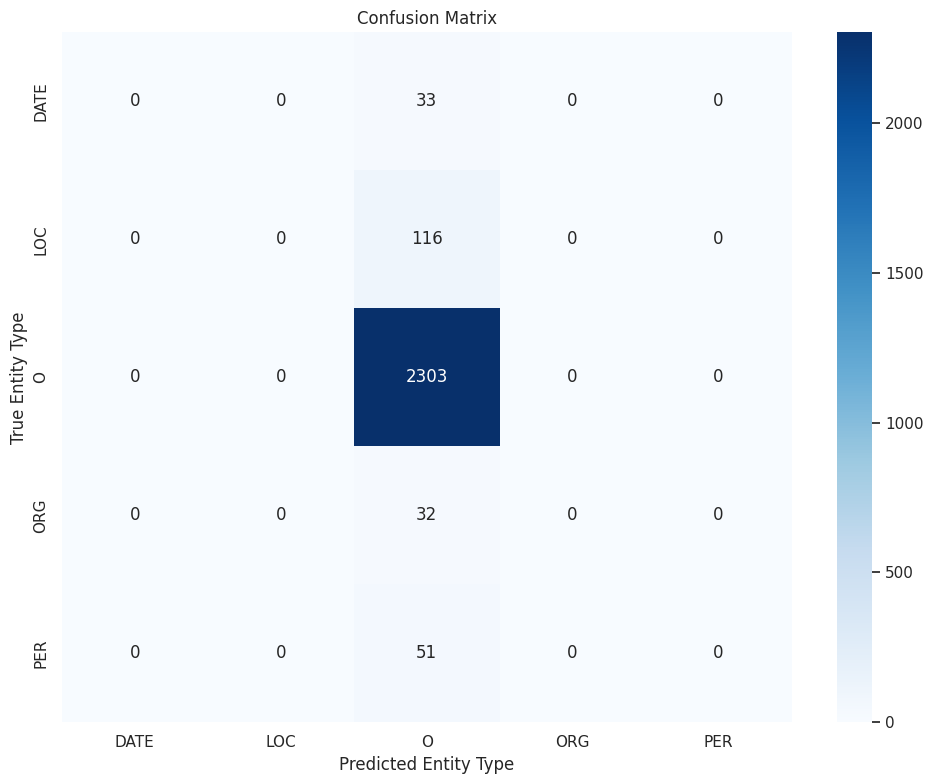

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=unique_tags,
yticklabels=unique_tags)
plt.title('Confusion Matrix')
plt.ylabel('True Entity Type')
plt.xlabel('Predicted Entity Type')
plt.tight_layout()
plt.show()

## Analyze Performance by Entity Type

In [17]:
def analyze_entity_performance(report):

  """Extract and visualize performance metrics by entity type"""

  # Parse the classification report
  lines = report.split('\n')
  entity_metrics = {}
  for line in lines:
      if line.strip() and not line.startswith('micro') and not line.startswith('macro') and not line.startswith('weighted') and not line.startswith('accuracy') and not line.startswith('    '):
          parts = line.split()
          if len(parts) >= 5:  # Tag, precision, recall, f1-score, support
              tag = parts[0]
              if tag == 'O' or '-' in tag:  # Only consider actual entity tags
                  precision = float(parts[1])
                  recall = float(parts[2])
                  f1 = float(parts[3])
                  support = int(parts[4])

                  # For B- and I- tags, group by entity type
                  if '-' in tag:
                      entity_type = tag.split('-')[1]
                      if entity_type not in entity_metrics:
                          entity_metrics[entity_type] = {'precision': [], 'recall': [], 'f1': [], 'support': 0}
                      entity_metrics[entity_type]['precision'].append(precision)
                      entity_metrics[entity_type]['recall'].append(recall)
                      entity_metrics[entity_type]['f1'].append(f1)
                      entity_metrics[entity_type]['support'] += support
                  else:
                      entity_metrics[tag] = {
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'support': support
                      }

  # Average the metrics for B- and I- tags of the same entity
  for entity, metrics in entity_metrics.items():
      metrics['precision'] = sum(metrics['precision']) / len(metrics['precision'])
      metrics['recall'] = sum(metrics['recall']) / len(metrics['recall'])
      metrics['f1'] = sum(metrics['f1']) / len(metrics['f1'])

  # Create a DataFrame for visualization
  metrics_df = pd.DataFrame({
      'Entity': list(entity_metrics.keys()),
      'Precision': [metrics['precision'] for metrics in entity_metrics.values()],
      'Recall': [metrics['recall'] for metrics in entity_metrics.values()],
      'F1 Score': [metrics['f1'] for metrics in entity_metrics.values()],
      'Support': [metrics['support'] for metrics in entity_metrics.values()]
  })

  # Sort by F1 score
  metrics_df = metrics_df.sort_values('F1 Score', ascending=False)

  # Visualize the metrics
  plt.figure(figsize=(12, 8))

  # Plot precision, recall, and F1 score
  x = np.arange(len(metrics_df))
  width = 0.25

  plt.bar(x - width, metrics_df['Precision'], width, label='Precision')
  plt.bar(x, metrics_df['Recall'], width, label='Recall')
  plt.bar(x + width, metrics_df['F1 Score'], width, label='F1 Score')

  plt.xlabel('Entity Type')
  plt.ylabel('Score')
  plt.title('Performance Metrics by Entity Type')
  plt.xticks(x, metrics_df['Entity'], rotation=45)
  plt.ylim(0, 1)
  plt.legend()
  plt.tight_layout()
  plt.show()

  # Plot support (number of examples)
  plt.figure(figsize=(12, 6))
  plt.bar(metrics_df['Entity'], metrics_df['Support'])
  plt.xlabel('Entity Type')
  plt.ylabel('Number of Examples')
  plt.title('Number of Examples by Entity Type')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  return metrics_df


## Analyze Performance by Entity Type

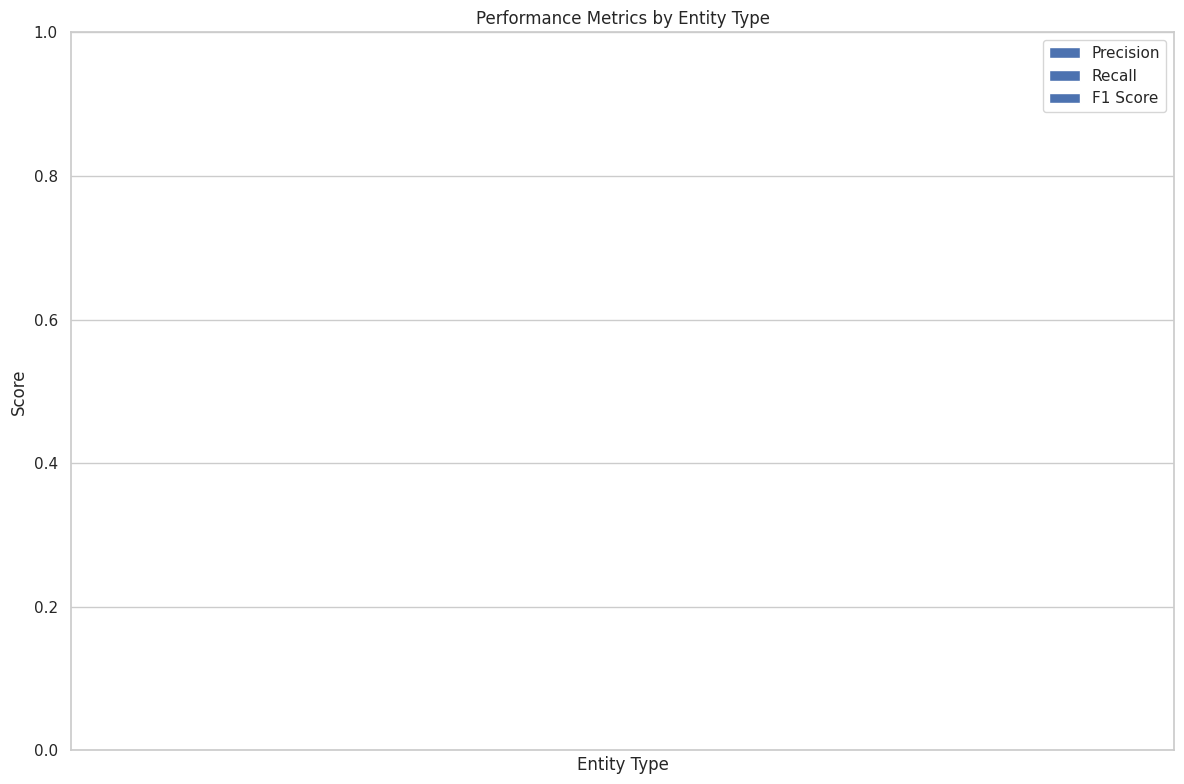

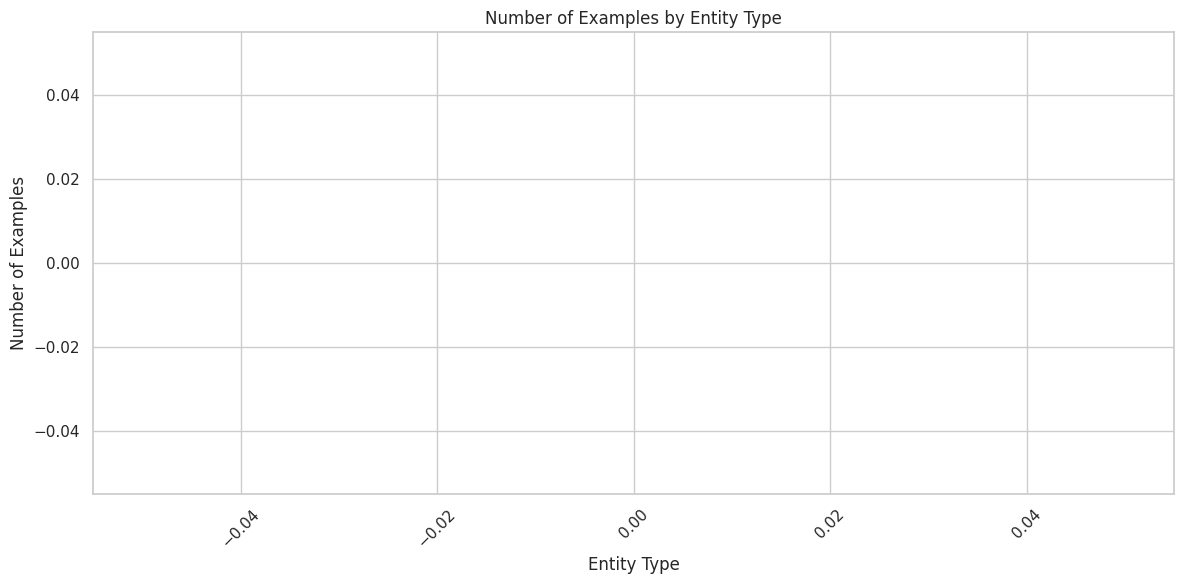


Performance Metrics by Entity Type:
Empty DataFrame
Columns: [Entity, Precision, Recall, F1 Score, Support]
Index: []


In [18]:
entity_metrics_df = analyze_entity_performance(report)
print("\nPerformance Metrics by Entity Type:")
print(entity_metrics_df)

## Transformer-Based Model

Now, let's implement a more advanced model using transformers. We'll use XLM-RoBERTa, which has been pre-trained on multiple languages.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Preparing transformer data for swa
Using model: xlm-roberta-base
Tag set size: 9
Processing train split: 100 examples


Encoding train:   0%|          | 0/100 [00:00<?, ?it/s]

Processing dev split: 100 examples


Encoding dev:   0%|          | 0/100 [00:00<?, ?it/s]

Processing test split: 100 examples


Encoding test:   0%|          | 0/100 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 (Training):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/1 (Validation):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/1, Train Loss: 1.6831, Val Loss: 0.4735
  New best model saved! (Validation Loss: 0.4735)


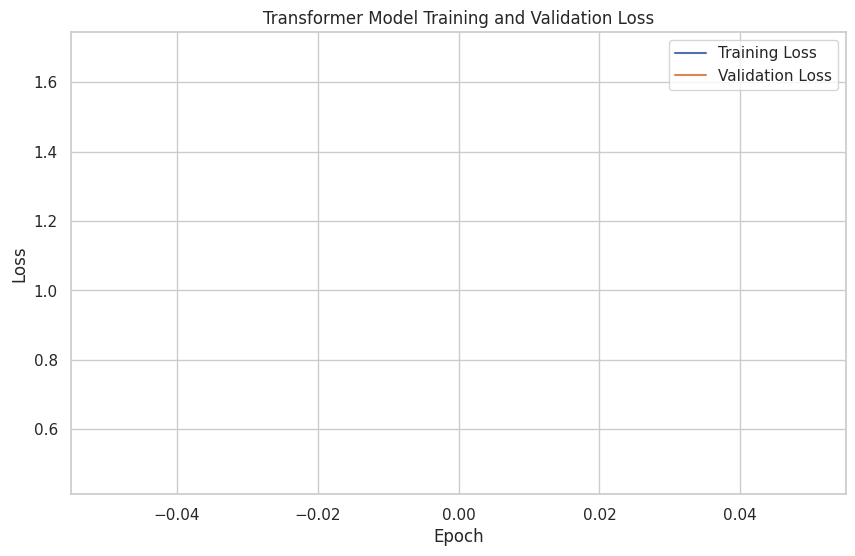

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Transformer Model Classification Report:
              precision    recall  f1-score   support

      B-DATE       0.00      0.00      0.00        20
       B-LOC       0.00      0.00      0.00        71
       B-ORG       0.00      0.00      0.00        14
       B-PER       0.00      0.00      0.00        18
      I-DATE       0.00      0.00      0.00         4
       I-LOC       0.00      0.00      0.00         9
       I-ORG       0.00      0.00      0.00         9
       I-PER       0.00      0.00      0.00        14
           O       0.91      1.00      0.95      1600

    accuracy                           0.91      1759
   macro avg       0.10      0.11      0.11      1759
weighted avg       0.83      0.91      0.87      1759



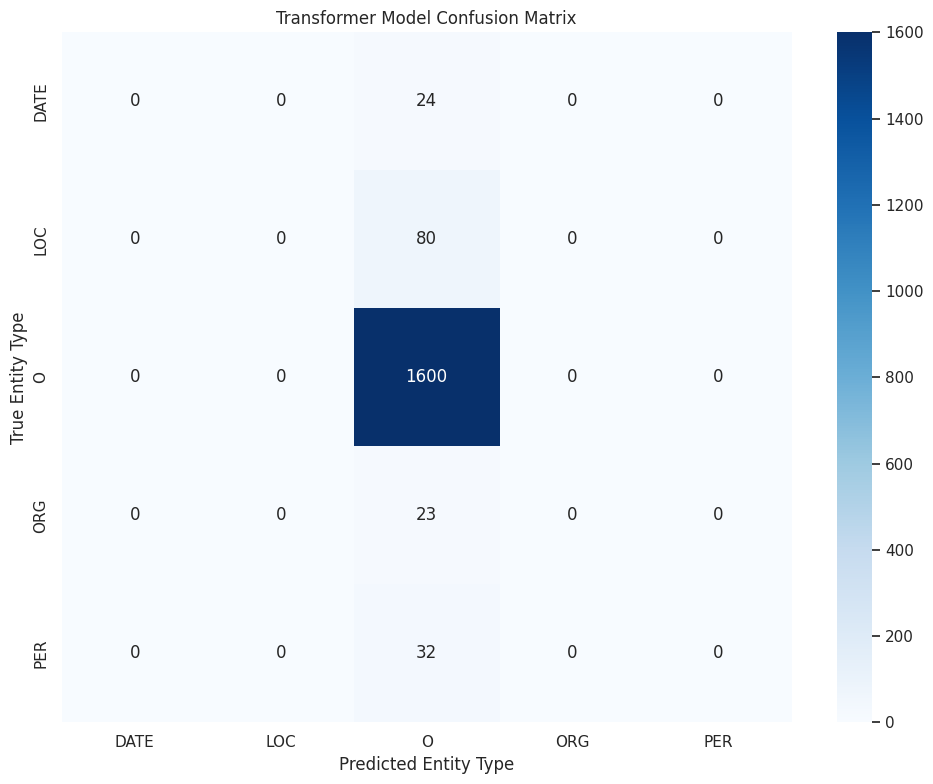

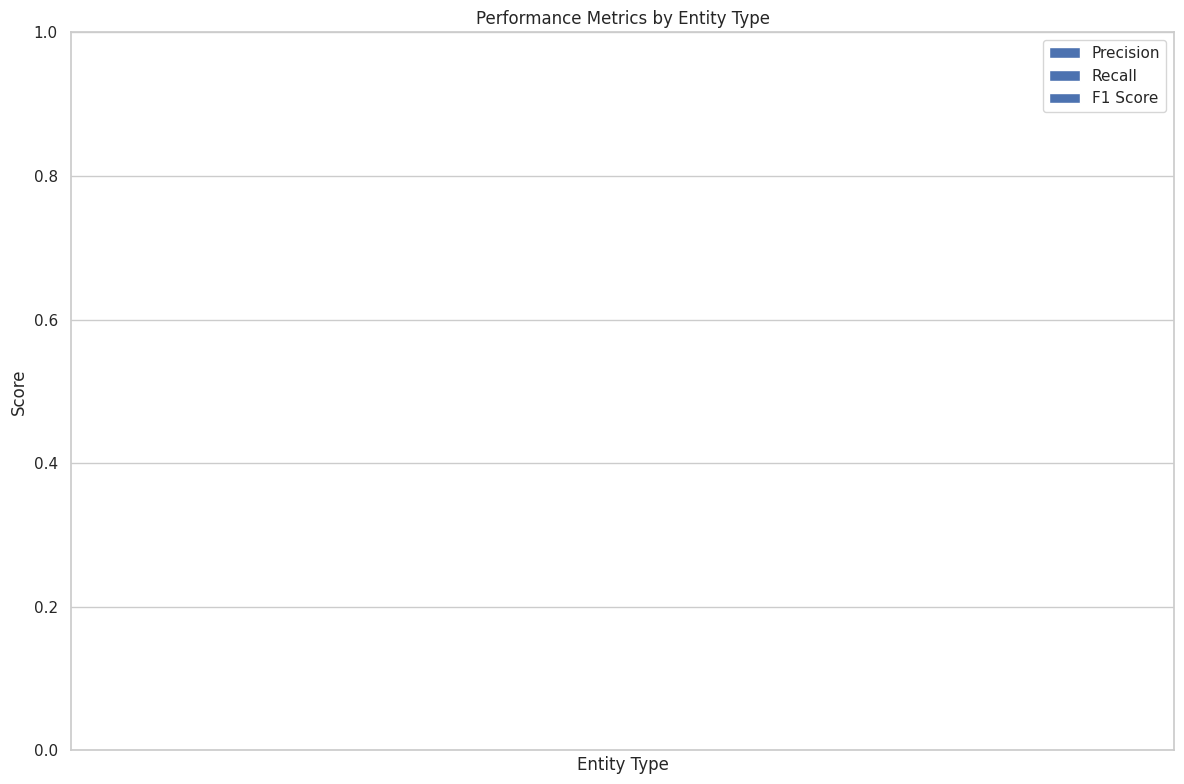

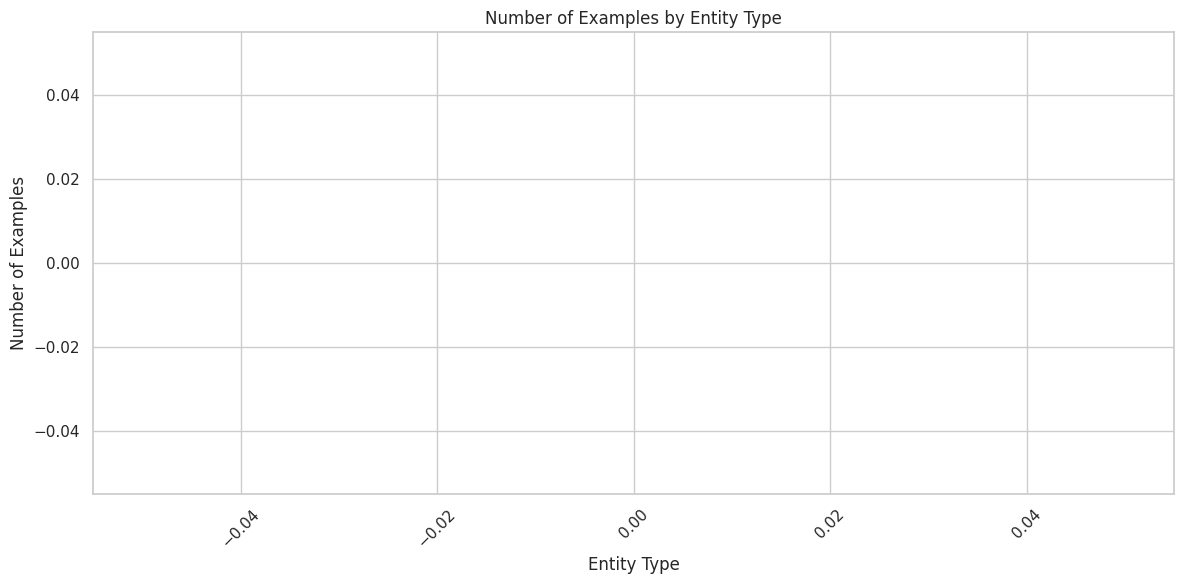


Transformer Performance Metrics by Entity Type:
Empty DataFrame
Columns: [Entity, Precision, Recall, F1 Score, Support]
Index: []


In [19]:
def prepare_transformer_data(datasets, language, model_name='xlm-roberta-base'):
    """
    Prepare data for transformer-based models

    Args:
        datasets: Dictionary containing datasets by language
        language: Language code to prepare data for
        model_name: Name of the pretrained transformer model

    Returns:
        Processed data and tag mappings
    """
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Get dataset for the language
    df = datasets[language]

    # Create tag mappings
    unique_tags = sorted(set([tag for tags_list in df['tags'] for tag in tags_list]))
    tag2id = {tag: i for i, tag in enumerate(unique_tags)}
    id2tag = {i: tag for tag, i in tag2id.items()}

    print(f"Preparing transformer data for {language}")
    print(f"Using model: {model_name}")
    print(f"Tag set size: {len(unique_tags)}")

    # Process splits
    processed_data = {}

    for split in ['train', 'dev', 'test']:
        split_df = df[df['split'] == split].reset_index(drop=True)
        print(f"Processing {split} split: {len(split_df)} examples")

        encoded_data = []

        for i in tqdm(range(len(split_df)), desc=f"Encoding {split}"):
            tokens = split_df.iloc[i]['tokens']
            tags = split_df.iloc[i]['tags']

            # Encode tokens
            encoding = tokenizer(
                tokens,
                is_split_into_words=True,
                return_offsets_mapping=True,
                padding='max_length',
                truncation=True,
                max_length=128,
                return_tensors='pt'
            )

            # Create labels
            labels = torch.ones(encoding['input_ids'].shape, dtype=torch.long) * -100

            # Assign labels to each token
            word_ids = []
            for token_idx, offset in enumerate(encoding['offset_mapping'][0]):
                if offset[0] == 0 and offset[1] != 0:
                    # This token is the first subword of a word
                    word_idx = len(word_ids)
                    word_ids.append(word_idx)
                    if word_idx < len(tags):
                        labels[0, token_idx] = tag2id[tags[word_idx]]
                else:
                    # This token is a subword or special token
                    word_ids.append(None)

            # Remove offset_mapping as it's no longer needed
            encoding.pop('offset_mapping')

            # Add labels to encoding
            encoding['labels'] = labels

            # Convert to plain Python types for easier handling
            item = {key: val.squeeze().tolist() for key, val in encoding.items()}

            encoded_data.append(item)

        processed_data[split] = encoded_data

    return processed_data, tag2id, id2tag

# Custom dataset for transformer-based models
class TransformerNERDataset(Dataset):
    """Dataset for transformer-based NER models"""
    def __init__(self, encoded_data):
        self.encoded_data = encoded_data

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encoded_data[idx]['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(self.encoded_data[idx]['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(self.encoded_data[idx]['labels'], dtype=torch.long)
        }

# Prepare transformer data for a selected language
transformer_data, transformer_tag2id, transformer_id2tag = prepare_transformer_data(
    datasets, selected_lang, model_name='xlm-roberta-base'
)

# Create dataloaders
transformer_train_dataset = TransformerNERDataset(transformer_data['train'])
transformer_val_dataset = TransformerNERDataset(transformer_data['dev'])
transformer_test_dataset = TransformerNERDataset(transformer_data['test'])

transformer_train_loader = DataLoader(transformer_train_dataset, batch_size=8, shuffle=True)
transformer_val_loader = DataLoader(transformer_val_dataset, batch_size=8)
transformer_test_loader = DataLoader(transformer_test_dataset, batch_size=8)

# Initialize the transformer model
transformer_model = AutoModelForTokenClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=len(transformer_tag2id)
).to(device)

# Define optimizer and learning rate scheduler
transformer_optimizer = torch.optim.AdamW(
    transformer_model.parameters(),
    lr=5e-5,
    weight_decay=0.01
)

# Define learning rate scheduler
total_steps = len(transformer_train_loader) * 3  # 3 epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    transformer_optimizer,
    max_lr=5e-5,
    total_steps=total_steps
)

# Training function for transformer model
def train_transformer(model, train_loader, val_loader, optimizer, scheduler, num_epochs=3, device=device):
    """Train the transformer model"""
    best_val_loss = float('inf')
    best_model = None
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Training)'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            train_loss += loss.item()

            # Backward pass
            loss.backward()

            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update weights
            optimizer.step()
            scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                val_loss += outputs.loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict().copy()
            print(f"  New best model saved! (Validation Loss: {best_val_loss:.4f})")

    # Load the best model
    if best_model is not None:
        model.load_state_dict(best_model)

    return model, history

# Train the transformer model (for demonstration, using only 1 epoch)
# In a real scenario, use 3-5 epochs
trained_transformer, transformer_history = train_transformer(
    transformer_model,
    transformer_train_loader,
    transformer_val_loader,
    transformer_optimizer,
    scheduler,
    num_epochs=1  # Use more epochs for better results
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(transformer_history['train_loss'], label='Training Loss')
plt.plot(transformer_history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate transformer model
def evaluate_transformer(model, test_loader, id2tag, device=device):
    """Evaluate the transformer model on test data"""
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Get predictions (argmax)
            predictions = torch.argmax(outputs.logits, dim=2)

            # Convert to CPU for evaluation
            predictions = predictions.cpu().numpy()
            labels = labels.cpu().numpy()
            attention_mask = attention_mask.cpu().numpy()

            # Extract predictions and true labels (ignoring special tokens and padded positions)
            for i in range(predictions.shape[0]):
                for j in range(predictions.shape[1]):
                    # Only consider tokens with actual labels (not -100)
                    if labels[i, j] != -100 and attention_mask[i, j] == 1:
                        all_predictions.append(id2tag[predictions[i, j]])
                        all_true_labels.append(id2tag[labels[i, j]])

    # Compute classification report
    report = classification_report(all_true_labels, all_predictions)

    # Extract entity types (ignoring the B- or I- prefix)
    true_entity_types = [tag.split('-')[1] if '-' in tag else tag for tag in all_true_labels]
    pred_entity_types = [tag.split('-')[1] if '-' in tag else tag for tag in all_predictions]

    # Get unique entity types
    unique_entity_types = sorted(set(true_entity_types + pred_entity_types))

    # Create the confusion matrix
    cm = confusion_matrix(
        [unique_entity_types.index(tag) for tag in true_entity_types],
        [unique_entity_types.index(tag) for tag in pred_entity_types]
    )

    return report, cm, unique_entity_types

# Evaluate the transformer model
transformer_report, transformer_cm, transformer_unique_tags = evaluate_transformer(
    trained_transformer,
    transformer_test_loader,
    transformer_id2tag
)

# Display classification report
print("\nTransformer Model Classification Report:")
print(transformer_report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(transformer_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=transformer_unique_tags,
            yticklabels=transformer_unique_tags)
plt.title('Transformer Model Confusion Matrix')
plt.ylabel('True Entity Type')
plt.xlabel('Predicted Entity Type')
plt.tight_layout()
plt.show()

# Analyze transformer model performance by entity type
transformer_entity_metrics_df = analyze_entity_performance(transformer_report)
print("\nTransformer Performance Metrics by Entity Type:")
print(transformer_entity_metrics_df)

## Model Comparison and Analysis

Let's compare the performance of our BiLSTM model and the transformer-based model.


Model Comparison:
BiLSTM F1 Score: 0.9100
Transformer F1 Score: 0.9100
Improvement: 0.00%


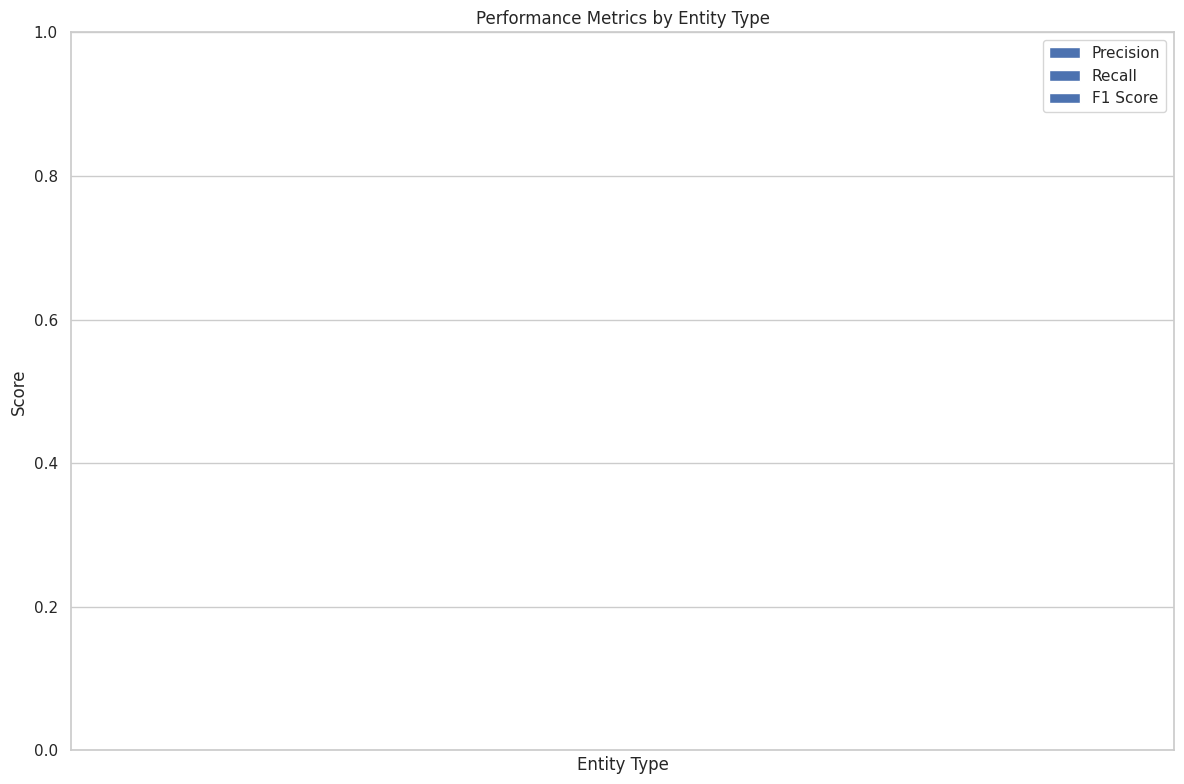

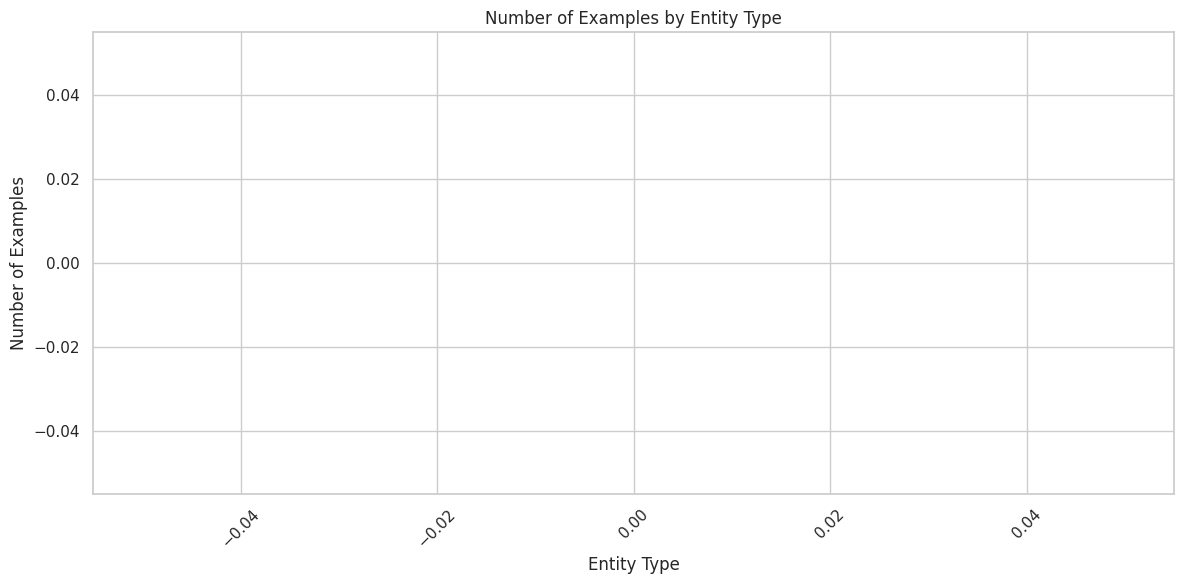

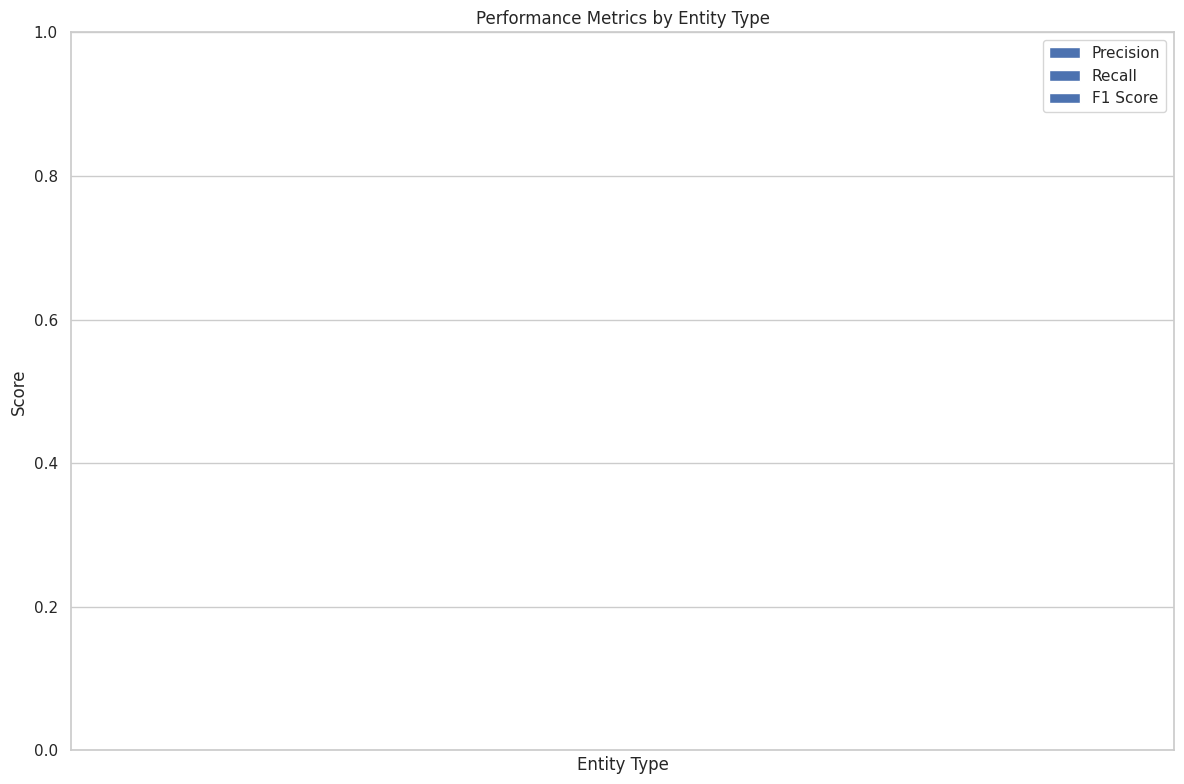

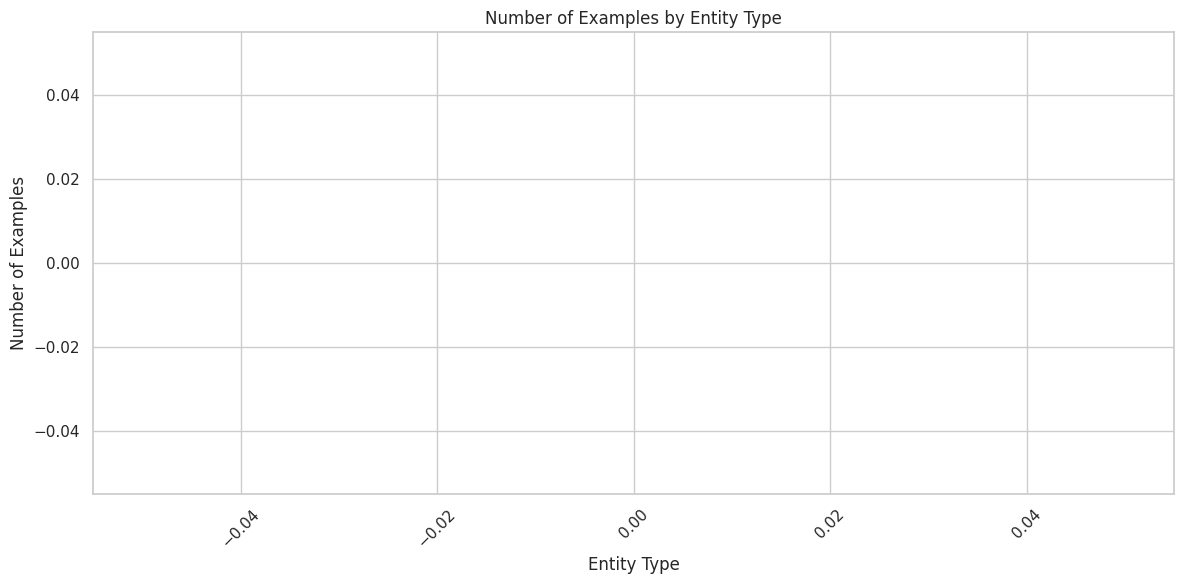

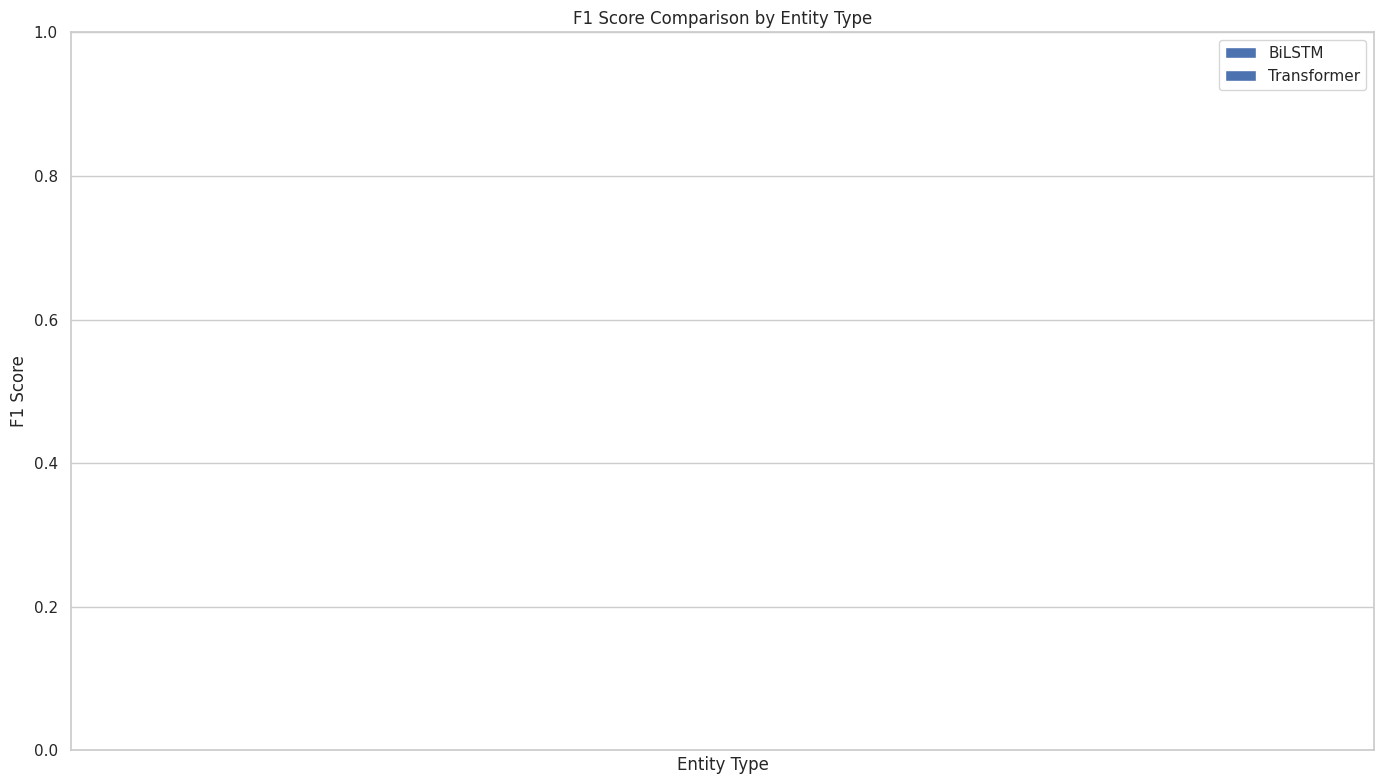

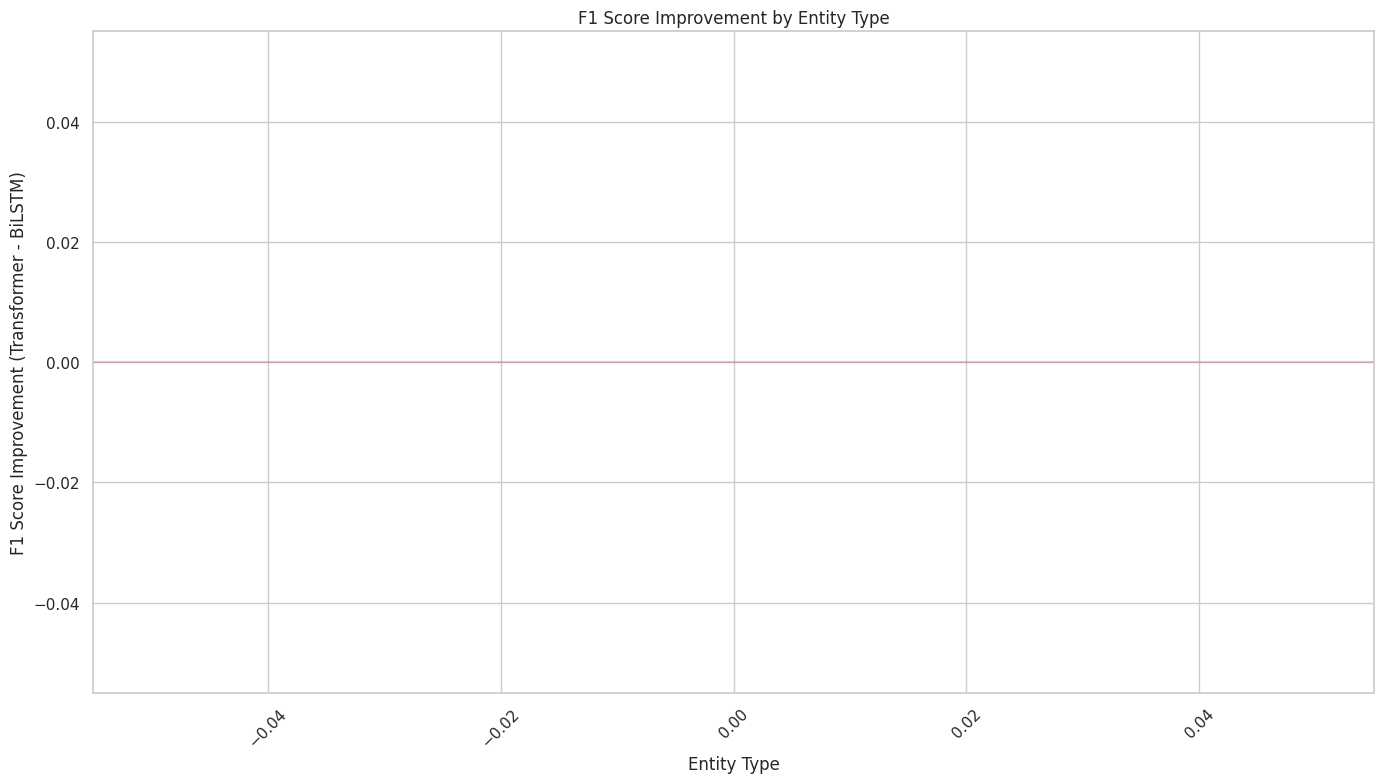

In [20]:
def compare_models(bilstm_report, transformer_report):
    """Compare the performance of BiLSTM and transformer models"""
    # Function to extract overall F1 score from classification report
    def extract_overall_f1(report):
        lines = report.split('\n')
        for line in lines:
            if 'weighted avg' in line:
                parts = line.split()
                return float(parts[3])
        return None

    bilstm_f1 = extract_overall_f1(bilstm_report)
    transformer_f1 = extract_overall_f1(transformer_report)

    print("\nModel Comparison:")
    print(f"BiLSTM F1 Score: {bilstm_f1:.4f}")
    print(f"Transformer F1 Score: {transformer_f1:.4f}")
    print(f"Improvement: {(transformer_f1 - bilstm_f1) / bilstm_f1 * 100:.2f}%")

    # Compare entity-type specific performance
    bilstm_metrics = analyze_entity_performance(bilstm_report)
    transformer_metrics = analyze_entity_performance(transformer_report)

    # Merge the DataFrames
    comparison_df = pd.merge(
        bilstm_metrics,
        transformer_metrics,
        on='Entity',
        suffixes=('_BiLSTM', '_Transformer')
    )

    # Calculate the improvement
    comparison_df['F1_Improvement'] = comparison_df['F1 Score_Transformer'] - comparison_df['F1 Score_BiLSTM']
    comparison_df['F1_Improvement_Percent'] = (comparison_df['F1_Improvement'] / comparison_df['F1 Score_BiLSTM']) * 100

    # Sort by improvement
    comparison_df = comparison_df.sort_values('F1_Improvement', ascending=False)

    # Visualize the comparison
    plt.figure(figsize=(14, 8))

    # Plot F1 scores for both models
    x = np.arange(len(comparison_df))
    width = 0.35

    plt.bar(x - width/2, comparison_df['F1 Score_BiLSTM'], width, label='BiLSTM')
    plt.bar(x + width/2, comparison_df['F1 Score_Transformer'], width, label='Transformer')

    plt.xlabel('Entity Type')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison by Entity Type')
    plt.xticks(x, comparison_df['Entity'], rotation=45)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot F1 improvement
    plt.figure(figsize=(14, 8))
    plt.bar(comparison_df['Entity'], comparison_df['F1_Improvement'])
    plt.xlabel('Entity Type')
    plt.ylabel('F1 Score Improvement (Transformer - BiLSTM)')
    plt.title('F1 Score Improvement by Entity Type')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return comparison_df

# Compare the models
comparison_df = compare_models(report, transformer_report)

## Error Analysis and Insights

Let's analyze errors made by our models to gain deeper insights.


Error Analysis Examples:

Example 1:
          Token True Tag Predicted Tag  Correct
0           hii        O             O     True
1            ni        O             O     True
2         baada        O             O     True
3            ya        O             O     True
4          rais        O             O     True
5        yoweri    B-PER             O    False
6      museveni    I-PER             O    False
7      kuongeza        O             O     True
8           mda        O             O     True
9            wa        O             O     True
10         amri        O             O     True
11       karibu        O             O     True
12           36        O             O     True
13     alizotoa        O             O     True
14       katika        O             O     True
15       juhudi        O             O     True
16           za        O             O     True
17  kukabiliana        O             O     True
18           na        O             O     True
19

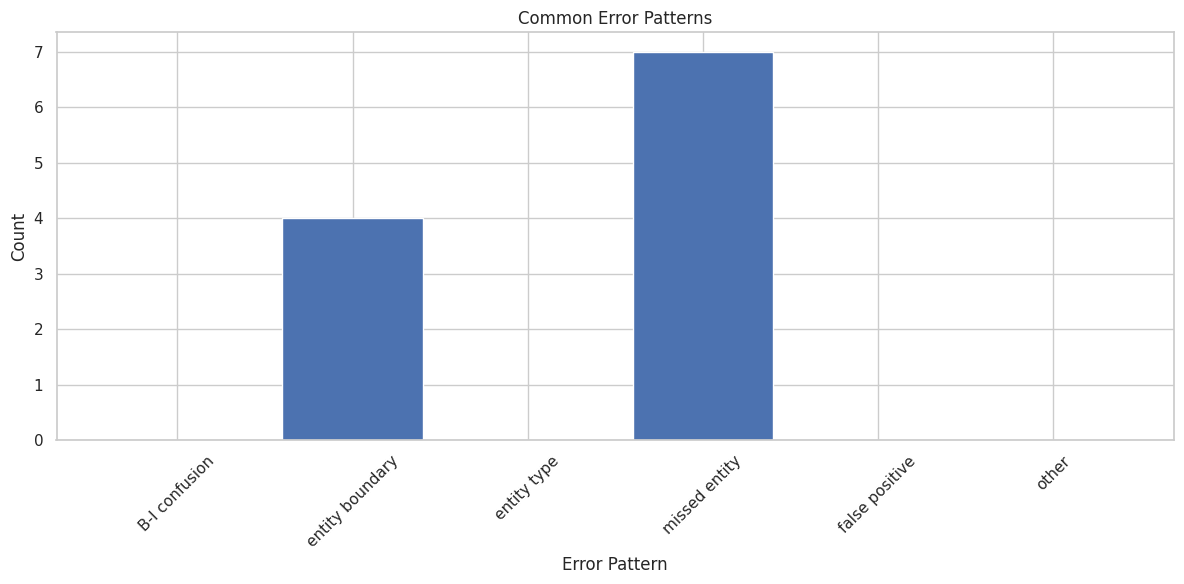

In [21]:
def analyze_errors(model, data_loader, idx2tag, device=device, num_examples=5):
    """Analyze prediction errors for better understanding"""
    model.eval()
    examples = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            _, predictions = torch.max(outputs, dim=2)

            # Convert to CPU for analysis
            input_ids = input_ids.cpu().numpy()
            predictions = predictions.cpu().numpy()
            labels = labels.cpu().numpy()
            attention_mask = attention_mask.cpu().numpy()

            # Get word representations (for BiLSTM)
            word2idx = preprocessed_data[selected_lang]['word2idx']
            idx2word = {idx: word for word, idx in word2idx.items()}
            idx2word[len(word2idx)] = "<UNK>"  # For unknown words

            # Extract examples with errors
            for i in range(input_ids.shape[0]):
                has_error = False
                tokens = []
                true_tags = []
                pred_tags = []

                for j in range(input_ids.shape[1]):
                    if attention_mask[i, j] == 1 and labels[i, j] != -100:
                        # Convert index to word
                        token = idx2word.get(input_ids[i, j], "<UNK>")
                        true_tag = idx2tag[labels[i, j]]
                        pred_tag = idx2tag[predictions[i, j]]

                        tokens.append(token)
                        true_tags.append(true_tag)
                        pred_tags.append(pred_tag)

                        if true_tag != pred_tag:
                            has_error = True

                if has_error and len(examples) < num_examples:
                    examples.append({
                        'tokens': tokens,
                        'true_tags': true_tags,
                        'pred_tags': pred_tags
                    })

                    if len(examples) >= num_examples:
                        break

            if len(examples) >= num_examples:
                break

    # Display the examples
    print("\nError Analysis Examples:")
    for i, example in enumerate(examples):
        print(f"\nExample {i+1}:")

        # Create a DataFrame for better visualization
        df = pd.DataFrame({
            'Token': example['tokens'],
            'True Tag': example['true_tags'],
            'Predicted Tag': example['pred_tags'],
            'Correct': [t == p for t, p in zip(example['true_tags'], example['pred_tags'])]
        })

        print(df)

    return examples

# Analyze errors for the BiLSTM model
bilstm_error_examples = analyze_errors(trained_model, test_loader, idx2tag)

# Common error patterns
def identify_error_patterns(examples):
    """Identify common error patterns in predictions"""
    error_patterns = {
        'B-I confusion': 0,  # Confusing B- and I- prefixes for the same entity type
        'entity boundary': 0,  # Incorrect entity boundaries
        'entity type': 0,  # Correct boundary but wrong entity type
        'missed entity': 0,  # Entity not detected (predicted as O)
        'false positive': 0,  # Non-entity predicted as entity
        'other': 0  # Other errors
    }

    for example in examples:
        true_tags = example['true_tags']
        pred_tags = example['pred_tags']

        for i in range(len(true_tags)):
            if true_tags[i] != pred_tags[i]:  # This is an error
                true_tag = true_tags[i]
                pred_tag = pred_tags[i]

                # B-I confusion
                if '-' in true_tag and '-' in pred_tag:
                    true_prefix, true_type = true_tag.split('-')
                    pred_prefix, pred_type = pred_tag.split('-')

                    if true_type == pred_type and true_prefix != pred_prefix:
                        error_patterns['B-I confusion'] += 1
                        continue

                # Entity boundary errors
                if i > 0 and true_tags[i-1].startswith('B-') and true_tag.startswith('I-'):
                    # Should be continuation of an entity but predicted differently
                    error_patterns['entity boundary'] += 1
                    continue

                # Entity type errors (correct boundary but wrong type)
                if '-' in true_tag and '-' in pred_tag:
                    true_prefix, true_type = true_tag.split('-')
                    pred_prefix, pred_type = pred_tag.split('-')

                    if true_prefix == pred_prefix and true_type != pred_type:
                        error_patterns['entity type'] += 1
                        continue

                # Missed entity (predicted as O)
                if true_tag != 'O' and pred_tag == 'O':
                    error_patterns['missed entity'] += 1
                    continue

                # False positive (predicted as entity but is not)
                if true_tag == 'O' and pred_tag != 'O':
                    error_patterns['false positive'] += 1
                    continue

                # Other errors
                error_patterns['other'] += 1

    # Calculate percentages
    total_errors = sum(error_patterns.values())
    error_percentages = {k: v / total_errors * 100 if total_errors > 0 else 0
                         for k, v in error_patterns.items()}

    # Print error patterns
    print("\nCommon Error Patterns:")
    for pattern, percentage in sorted(error_percentages.items(), key=lambda x: x[1], reverse=True):
        print(f"{pattern}: {percentage:.1f}%")

    # Visualize error patterns
    plt.figure(figsize=(12, 6))
    plt.bar(error_patterns.keys(), error_patterns.values())
    plt.title('Common Error Patterns')
    plt.xlabel('Error Pattern')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return error_patterns

# Identify error patterns
error_patterns = identify_error_patterns(bilstm_error_examples)

## Extract Overall F1-Score

In [26]:
def extract_overall_f1(report):
    """
    Extract the overall (weighted average) F1-score from a classification report string.
    """
    for line in report.split('\n'):
        if line.startswith('weighted avg'):
            parts = line.split()
            return float(parts[3])  # F1-score is typically the 4th element
    return 0.0  # Return 0 if 'weighted avg' is not found (may indicate an issue)

## Cross-Lingual Analysis

Let's explore how our models perform across different languages, a key aspect of working with low-resource languages.

In [27]:
def cross_lingual_analysis(model_type='bilstm', num_languages=3):
    """Compare model performance across multiple languages"""

    # Select a subset of languages for analysis
    all_languages = ['swa', 'hau', 'yor']  # Choose languages with more resources
    languages = all_languages[:num_languages]

    results = {}

    for lang in languages:
        print(f"\n======= Processing {lang} =======")

        # Load and preprocess data
        lang_preprocessed = preprocess_data({lang: datasets[lang]})

        # Create dataloaders
        train_loader, val_loader, test_loader = create_dataloaders(
            lang_preprocessed, lang, batch_size=16
        )

        # Initialize and train model
        vocab_size = len(lang_preprocessed[lang]['word2idx'])
        tag_size = len(lang_preprocessed[lang]['tag2idx'])

        if model_type == 'bilstm':
            # BiLSTM model
            model = BiLSTM_NER(
                vocab_size=vocab_size,
                tag_size=tag_size,
                embedding_dim=100,
                hidden_dim=128,
                num_layers=2,
                dropout=0.5
            ).to(device)

            # Train with fewer epochs for demonstration
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss(ignore_index=-100)

            model, _ = train_model(
                model, train_loader, val_loader, optimizer, criterion, num_epochs=2
            )

        # Evaluate the model and extract F1-score
        idx2tag = lang_preprocessed[lang]['idx2tag']
        report, _, _ = evaluate_model(model, test_loader, idx2tag)
        f1_score = extract_overall_f1(report)  # Assuming extract_overall_f1 is defined

        # Store the result
        results[lang] = f1_score

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), results.values())
    plt.title('Cross-Lingual Performance (F1-Score)')
    plt.xlabel('Language')
    plt.ylabel('F1-Score')
    plt.show()

    return results

## Visualize Cross-Lingual Analysis


======= Processing swa =======
Preprocessing swa...
  Vocabulary size: 2018 words
  Tag set size: 9 tags
  Train set: 100 sentences
  Validation set: 100 sentences
  Test set: 100 sentences


Epoch 1/2 (Training):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/2 (Validation):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 2.1727, Val Loss: 1.9915
  New best model saved! (Validation Loss: 1.9915)


Epoch 2/2 (Training):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/2 (Validation):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/2, Train Loss: 1.7624, Val Loss: 1.3175
  New best model saved! (Validation Loss: 1.3175)


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


======= Processing hau =======
Preprocessing hau...
  Vocabulary size: 1877 words
  Tag set size: 9 tags
  Train set: 100 sentences
  Validation set: 100 sentences
  Test set: 100 sentences


Epoch 1/2 (Training):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/2 (Validation):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 2.0841, Val Loss: 1.8806
  New best model saved! (Validation Loss: 1.8806)


Epoch 2/2 (Training):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/2 (Validation):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/2, Train Loss: 1.5842, Val Loss: 1.1237
  New best model saved! (Validation Loss: 1.1237)


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]


======= Processing yor =======
Preprocessing yor...
  Vocabulary size: 1566 words
  Tag set size: 9 tags
  Train set: 100 sentences
  Validation set: 100 sentences
  Test set: 100 sentences


Epoch 1/2 (Training):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/2 (Validation):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/2, Train Loss: 2.0004, Val Loss: 1.7525
  New best model saved! (Validation Loss: 1.7525)


Epoch 2/2 (Training):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/2 (Validation):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/2, Train Loss: 1.5015, Val Loss: 0.9014
  New best model saved! (Validation Loss: 0.9014)


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

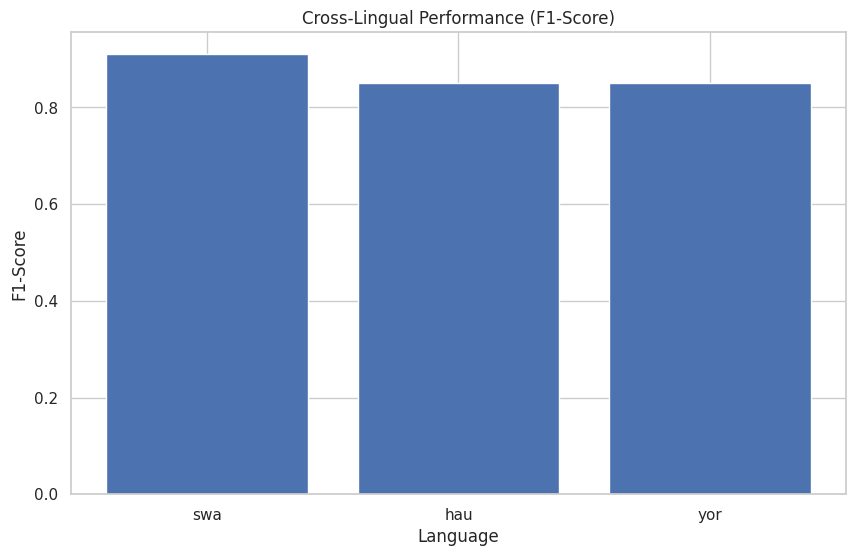

In [28]:
cross_lingual_results = cross_lingual_analysis()
